Element resolution from an arbitrary spectra is likely going to be a multivariate fitting so this notebook explores available optimization libraries in python. 
Advancing LIBS to calibration free estimation may involve allowing for variation in plasma conditions by element and time. For example, if certain ions are emitting at differnt points then the plasma temp/density can vary across the lines observed. In fitting the observed data we may be able to estimate these parameters from relative line strengths observed. Alternatively we could allow these parameters to vary to determine optimal fit. The implied sample elemental composition will be better fit.

Breaking each element down into ionization states and the associated energies/probabilities as f(Temp,dens) each could be fit separately and normalized to a reference Temp/Dens upon which full elemental composition could be estimated.

SciPy is a good starting point for optimization routines, though there are additional python libraries available to review.
https://docs.scipy.org/doc/scipy/tutorial/optimize.html

In [2]:
import numpy as np
from scipy.optimize import minimize

In [3]:
#objective function must have signature f(x, *args) where x is numpy array
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

In [4]:
#nelder-mead is a simplex algorithm and does not use gradient (Powell also needs only function calls)
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571


In [5]:
print(res.x)

[1. 1. 1. 1. 1.]


In [6]:
#Faster convergence from methods that include a gradient, Can be passed or estimated from first diffs
#Broyden-Fletcher-Goldfarb-Shanno algorithm (method='BFGS')
res = minimize(rosen, x0, method='BFGS', options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 180
         Gradient evaluations: 30


In [7]:
#include the gradient explicitly, best in the objective def which now returns a tuple
def rosen_and_der(x):
    objective = sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return objective, der

In [8]:
#note if sep fxn for jacobian, specify that as jac arg
res = minimize(rosen_and_der, x0, method='BFGS', jac=True, options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30


In [9]:
#standalond jacobian for next method call
def rosen_der(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

In [10]:
#Newton-conjugate takes second derivative into account via Hessian matrix
#Basically a two-term Taylor expansion
def rosen_hess(x):
    x = np.asarray(x)
    H = np.diag(-400*x[:-1],1) - np.diag(400*x[:-1],-1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]
    H = H + np.diag(diagonal)
    return H

In [11]:
#note, another form allows for hessp= which is function giving product of Hessian with arb vector p
res = minimize(rosen, x0, method='Newton-CG',
                jac=rosen_der, hess=rosen_hess,
                options={'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 33
         Hessian evaluations: 24


In [12]:
#Trust-Region Newton-Conjugate-Gradient Algorithm
res = minimize(rosen, x0, method='trust-ncg',
                    jac=rosen_der, hess=rosen_hess,
                    options={'gtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 20
         Hessian evaluations: 19


In [13]:
#more efficient trust region implementation for larger problems
res = minimize(rosen, x0, method='trust-krylov',
        jac=rosen_der, hess=rosen_hess,
        options={'gtol': 1e-8, 'disp': True})

 iter inewton type    objective     âgââ_Mâ»Â¹      leftmost         Î»             Î³             Î´             Î±             Î²       
     0     0  cg_i -6.273083e+02  4.029038e+02  0.000000e+00  0.000000e+00  2.246107e+03  4.021147e+03  2.486853e-04  3.217671e-02

 iter inewton type    objective     âgââ_Mâ»Â¹      leftmost         Î»             Î³             Î´             Î±             Î²       
     0     0  cg_i -9.528585e+01  1.478412e+02  0.000000e+00  0.000000e+00  6.001708e+02  1.890129e+03  5.290645e-04  6.067939e-02

 iter inewton type    objective     âgââ_Mâ»Â¹      leftmost         Î»             Î³             Î´             Î±             Î²       
     0     0  cg_i -8.662599e+00  5.824611e+01  0.000000e+00  0.000000e+00  1.285783e+02  9.542387e+02  1.047956e-03  2.052100e-01

 iter inewton type    objective     âgââ_Mâ»Â¹      leftmost         Î»             Î³             Î´             Î±             Î²       
     0     0  cg_i -

In [14]:
#method that factorizes Hessian is faster and can be used for smaller problems
res = minimize(rosen, x0, method='trust-exact',
    jac=rosen_der, hess=rosen_hess,
    options={'gtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 13
         Hessian evaluations: 14


In [15]:
#Many minimization problems are constrained so there are methods for these
#consider minimizing 100(x1 - x0)^2 + (1 -x0)^2
#subject to variable bounds: 0 <= x0 <= 1 and -0.5 <= x1 <= 2.0
from scipy.optimize import Bounds
bounds = Bounds([0, -0.5], [1.0, 2.0])

In [16]:
#Then also subject to linear constraints (function of variables)
# x0 + 2x1 <= 1 and 2x0 + x1 = 1 (use np.inf for absence of bound on either side)
from scipy.optimize import LinearConstraint
linear_constraint = LinearConstraint([[1, 2], [2, 1]], [-np.inf, 1], [1, 1])

In [17]:
#you can even have non-linear constraints such as 
# x0^2 + x1 <= 1 and x0^2 - 1 <= 1
#provide Jacobian (grad)
# J = [[2x0, 1], [2x0, -1]]
#Linear combination of hessians
# H(x,v) = v0*[[2,0], [0,0]] + v1*[[2,0], [0,0]]

In [18]:
def cons_f(x):
    return [x[0]**2 + x[1], x[0]**2 - x[1]]
def cons_J(x):
    return [[2*x[0], 1], [2*x[0], -1]]
def cons_H(x, v):
    return v[0]*np.array([[2, 0], [0, 0]]) + v[1]*np.array([[2, 0], [0, 0]])
from scipy.optimize import NonlinearConstraint
nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 1, jac=cons_J, hess=cons_H)

In [19]:
#Can define Hessian as a sparse matrix
from scipy.sparse import csc_matrix
def cons_H_sparse(x, v):
    return v[0]*csc_matrix([[2, 0], [0, 0]]) + v[1]*csc_matrix([[2, 0], [0, 0]])
nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 1, 
                                           jac=cons_J, hess=cons_H_sparse)

In [20]:
#also can define Hessian as linear operator
from scipy.sparse.linalg import LinearOperator
def cons_H_linear_operator(x, v):
    def matvec(p):
        return np.array([p[0]*2*(v[0]+v[1]), 0])
    return LinearOperator((2, 2), matvec=matvec)
nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 1,
                                           jac=cons_J, hess=cons_H_linear_operator)

In [21]:
x0 = np.array([0.5, 0])
res = minimize(rosen, x0, method='trust-constr', jac=rosen_der, hess=rosen_hess,
                constraints=[linear_constraint, nonlinear_constraint],
                options={'verbose': 1}, bounds=bounds)

`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 8, CG iterations: 7, optimality: 2.99e-09, constraint violation: 0.00e+00, execution time: 0.03 s.


In [22]:
res.x 

array([0.41494531, 0.17010937])

In [23]:
#If Hessian difficult can use Hessian update strategy BFGS or SR1
from scipy.optimize import BFGS
nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 1, jac=cons_J, hess=BFGS())
x0 = np.array([0.5, 0])
res = minimize(rosen, x0, method='trust-constr', jac=rosen_der, hess=rosen_hess,
                constraints=[linear_constraint, nonlinear_constraint],
                options={'verbose': 1}, bounds=bounds)
res.x

`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 8, CG iterations: 7, optimality: 2.99e-09, constraint violation: 0.00e+00, execution time: 0.033 s.


array([0.41494531, 0.17010937])

In [24]:
#or approximate Hessian with finite differences
nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 1, jac=cons_J, hess='2-point')
x0 = np.array([0.5, 0])
res = minimize(rosen, x0, method='trust-constr', jac=rosen_der, hess=rosen_hess,
                constraints=[linear_constraint, nonlinear_constraint],
                options={'verbose': 1}, bounds=bounds)
res.x

`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 8, CG iterations: 7, optimality: 2.99e-09, constraint violation: 0.00e+00, execution time: 0.045 s.


array([0.41494531, 0.17010937])

In [25]:
#Jacobian can be approximated with finite differences
#but then Hessian cannot be and another method used
nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 1, jac='2-point', hess=BFGS())
x0 = np.array([0.5, 0])
res = minimize(rosen, x0, method='trust-constr', jac=rosen_der, hess=rosen_hess,
                constraints=[linear_constraint, nonlinear_constraint],
                options={'verbose': 1}, bounds=bounds)
res.x

`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 8, CG iterations: 7, optimality: 2.99e-09, constraint violation: 0.00e+00, execution time: 0.035 s.


array([0.41494531, 0.17010937])

In [27]:
#Objective Hessian can also be a linear operator
#form of hessian that returns product of Hessian with arb vector p
def rosen_hess_p(x, p):
    x = np.asarray(x)
    Hp = np.zeros_like(x)
    Hp[0] = (1200*x[0]**2 - 400*x[1] + 2)*p[0] - 400*x[0]*p[1]
    Hp[1:-1] = -400*x[:-2]*p[:-2]+(202+1200*x[1:-1]**2-400*x[2:])*p[1:-1] \
               -400*x[1:-1]*p[2:]
    Hp[-1] = -400*x[-2]*p[-2] + 200*p[-1]
    return Hp


def rosen_hess_linop(x):
    def matvec(p):
        return rosen_hess_p(x, p)
    return LinearOperator((2, 2), matvec=matvec)
res = minimize(rosen, x0, method='trust-constr', jac=rosen_der, hess=rosen_hess_linop,
                constraints=[linear_constraint, nonlinear_constraint],
                options={'verbose': 1}, bounds=bounds)
res.x

`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 8, CG iterations: 7, optimality: 2.99e-09, constraint violation: 0.00e+00, execution time: 0.057 s.


array([0.41494531, 0.17010937])

In [29]:
#or directly use the hessian vector prod
res = minimize(rosen, x0, method='trust-constr', jac=rosen_der, hessp=rosen_hess_p,
               constraints=[linear_constraint, nonlinear_constraint],
               options={'verbose': 1}, bounds=bounds)
res.x

`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 8, CG iterations: 7, optimality: 2.99e-09, constraint violation: 0.00e+00, execution time: 0.043 s.


array([0.41494531, 0.17010937])

In [31]:
#can still approx the first and second derivatives
from scipy.optimize import SR1
res = minimize(rosen, x0, method='trust-constr',  jac="2-point", hess=SR1(),
                constraints=[linear_constraint, nonlinear_constraint],
                options={'verbose': 1}, bounds=bounds)
res.x

`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 24, CG iterations: 7, optimality: 4.40e-09, constraint violation: 0.00e+00, execution time: 0.04 s.


array([0.41494531, 0.17010937])

In [32]:
#Sequential least squares is another constrained solver (unclear if distinct cases handled vs. trust-constr)
ineq_cons = {'type': 'ineq',
             'fun' : lambda x: np.array([1 - x[0] - 2*x[1],
                                         1 - x[0]**2 - x[1],
                                         1 - x[0]**2 + x[1]]),
             'jac' : lambda x: np.array([[-1.0, -2.0],
                                         [-2*x[0], -1.0],
                                         [-2*x[0], 1.0]])}
eq_cons = {'type': 'eq',
           'fun' : lambda x: np.array([2*x[0] + x[1] - 1]),
           'jac' : lambda x: np.array([2.0, 1.0])}
x0 = np.array([0.5, 0])
res = minimize(rosen, x0, method='SLSQP', jac=rosen_der,
               constraints=[eq_cons, ineq_cons], options={'ftol': 1e-9, 'disp': True},
               bounds=bounds)
res.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.34271757499419825
            Iterations: 4
            Function evaluations: 5
            Gradient evaluations: 4


array([0.41494475, 0.1701105 ])

In [33]:
#Global optimization handles situations with many local minima and efficiently searches for global min
#new objective function egg holder
def eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))
            -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))

bounds = [(-512, 512), (-512, 512)]

In [35]:

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xgrid.shape

(1025, 1025)

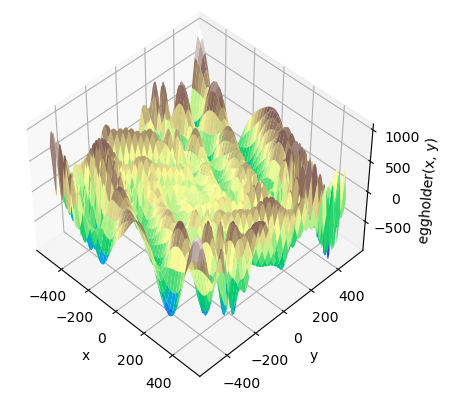

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('eggholder(x, y)')
plt.show()

In [52]:
from scipy import optimize
results = dict()
results['shgo'] = optimize.shgo(eggholder, bounds)
results['shgo']

     fun: -935.3379515605761
    funl: array([-935.33795156])
 message: 'Optimization terminated successfully.'
    nfev: 62
     nit: 2
   nlfev: 57
   nlhev: 0
   nljev: 14
 success: True
       x: array([439.48099854, 453.9774378 ])
      xl: array([[439.48099854, 453.9774378 ]])

In [53]:
results['DA'] = optimize.dual_annealing(eggholder, bounds)
results['DA']

     fun: -935.3379515600041
 message: ['Maximum number of iteration reached']
    nfev: 4058
    nhev: 0
     nit: 1000
    njev: 19
  status: 0
 success: True
       x: array([439.48104981, 453.97748943])

In [54]:
results['DE'] = optimize.differential_evolution(eggholder, bounds)
results['DE']

     fun: -959.640662720757
     jac: array([-3.38557997e+00,  1.13686748e-05])
 message: 'Optimization terminated successfully.'
    nfev: 1032
     nit: 33
 success: True
       x: array([512.       , 404.2318142])

In [55]:
results['shgo_sobol'] = optimize.shgo(eggholder, bounds, n=200, iters=5,
                                      sampling_method='sobol')
results['shgo_sobol']

     fun: -959.6406627208509
    funl: array([-959.64066272, -959.64066272, -959.64066272, -935.33795156,
       -935.33795156, -935.33795156, -935.33795156, -935.33795156,
       -935.33795156, -894.57890039, -894.57890039, -894.57890039,
       -894.57890039, -894.57890039, -894.57890039, -894.57890039,
       -894.57890039, -894.57890039, -894.57890039, -888.94912527,
       -888.94912527, -888.94912527, -888.94912527, -888.94912527,
       -821.19646107, -821.19646107, -821.19646107, -821.19646107,
       -821.19646107, -821.19646107, -821.19646107, -821.19646107,
       -821.19646107, -786.52599408, -786.52599408, -786.52599408,
       -786.52599408, -753.05015469, -753.05015469, -738.03782981,
       -738.03782981, -738.03782981, -738.03782981, -738.03782981,
       -738.03782981, -718.16745962, -718.16745962, -718.16745962,
       -718.16745962, -718.16745962, -718.16745962, -718.16745962,
       -716.67150034, -716.67150034, -716.67150034, -716.67150034,
       -716.67150034, -

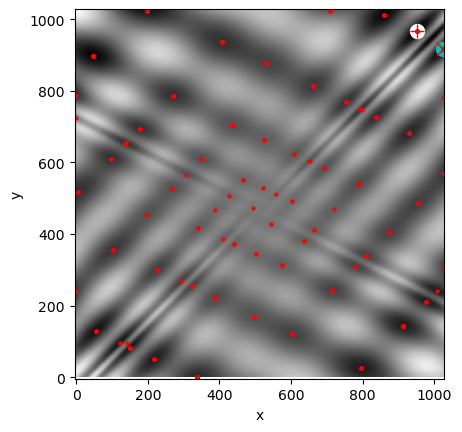

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(eggholder(xy), interpolation='bilinear', origin='lower',
               cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')

def plot_point(res, marker='o', color=None):
    ax.plot(512+res.x[0], 512+res.x[1], marker=marker, color=color, ms=10)

plot_point(results['DE'], color='c')  # differential_evolution - cyan
plot_point(results['DA'], color='w')  # dual_annealing.        - white

# SHGO produces multiple minima, plot them all (with a smaller marker size)
plot_point(results['shgo'], color='r', marker='+')
plot_point(results['shgo_sobol'], color='r', marker='x')
for i in range(results['shgo_sobol'].xl.shape[0]):
    ax.plot(512 + results['shgo_sobol'].xl[i, 0],
            512 + results['shgo_sobol'].xl[i, 1],
            'ro', ms=2)

ax.set_xlim([-4, 514*2])
ax.set_ylim([-4, 514*2])
plt.show()

In [57]:
#least squares function fitting (used in peak fitting notebook)
#This example fits x values based on residuals to function
#Analytical Jacobian is strongly recommended
from scipy.optimize import least_squares
def model(x, u):
    return x[0] * (u ** 2 + x[1] * u) / (u ** 2 + x[2] * u + x[3])
def fun(x, u, y):
    return model(x, u) - y
def jac(x, u, y):
    J = np.empty((u.size, x.size))
    den = u ** 2 + x[2] * u + x[3]
    num = u ** 2 + x[1] * u
    J[:, 0] = num / den
    J[:, 1] = x[0] * u / den
    J[:, 2] = -x[0] * num * u / den ** 2
    J[:, 3] = -x[0] * num / den ** 2
    return J
u = np.array([4.0, 2.0, 1.0, 5.0e-1, 2.5e-1, 1.67e-1, 1.25e-1, 1.0e-1,
              8.33e-2, 7.14e-2, 6.25e-2])
y = np.array([1.957e-1, 1.947e-1, 1.735e-1, 1.6e-1, 8.44e-2, 6.27e-2,
              4.56e-2, 3.42e-2, 3.23e-2, 2.35e-2, 2.46e-2])
x0 = np.array([2.5, 3.9, 4.15, 3.9])
res = least_squares(fun, x0, jac=jac, bounds=(0, 100), args=(u, y), verbose=1)
res.x

`ftol` termination condition is satisfied.
Function evaluations 131, initial cost 4.4383e+00, final cost 1.5375e-04, first-order optimality 4.52e-08.


array([0.192806  , 0.19130332, 0.12306046, 0.13607205])

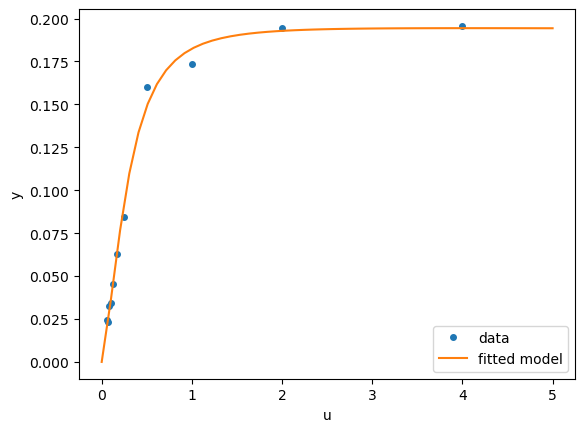

In [58]:
import matplotlib.pyplot as plt
u_test = np.linspace(0, 5)
y_test = model(res.x, u_test)
plt.plot(u, y, 'o', markersize=4, label='data')
plt.plot(u_test, y_test, label='fitted model')
plt.xlabel("u")
plt.ylabel("y")
plt.legend(loc='lower right')
plt.show()

In [59]:
#faster functions where univariate (scalar)
from scipy.optimize import minimize_scalar
f = lambda x: (x - 2) * (x + 1)**2
res = minimize_scalar(f, method='brent')
print(res.x)

1.0


In [60]:
#can bound
from scipy.special import j1
res = minimize_scalar(j1, bounds=(4, 7), method='bounded')
res.x

5.3314418424098315

In [61]:
type(j1)

numpy.ufunc

In [63]:
#Can write your own minimization functions and pass as callable
from scipy.optimize import OptimizeResult
def custmin(fun, x0, args=(), maxfev=None, stepsize=0.1,
        maxiter=100, callback=None, **options):
    bestx = x0
    besty = fun(x0)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        improved = False
        niter += 1
        for dim in range(np.size(x0)):
            for s in [bestx[dim] - stepsize, bestx[dim] + stepsize]:
                testx = np.copy(bestx)
                testx[dim] = s
                testy = fun(testx, *args)
                funcalls += 1
                if testy < besty:
                    besty = testy
                    bestx = testx
                    improved = True
            if callback is not None:
                callback(bestx)
            if maxfev is not None and funcalls >= maxfev:
                stop = True
                break

    return OptimizeResult(fun=besty, x=bestx, nit=niter,
                          nfev=funcalls, success=(niter > 1))
x0 = [1.35, 0.9, 0.8, 1.1, 1.2]
res = minimize(rosen, x0, method=custmin, options=dict(stepsize=0.05))
res.x

array([1., 1., 1., 1., 1.])

In [64]:
#also for univariate
def custmin(fun, bracket, args=(), maxfev=None, stepsize=0.1,
        maxiter=100, callback=None, **options):
    bestx = (bracket[1] + bracket[0]) / 2.0
    besty = fun(bestx)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        improved = False
        niter += 1
        for testx in [bestx - stepsize, bestx + stepsize]:
            testy = fun(testx, *args)
            funcalls += 1
            if testy < besty:
                besty = testy
                bestx = testx
                improved = True
        if callback is not None:
            callback(bestx)
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break

    return OptimizeResult(fun=besty, x=bestx, nit=niter,
                          nfev=funcalls, success=(niter > 1))
def f(x):
   return (x - 2)**2 * (x + 2)**2
res = minimize_scalar(f, bracket=(-3.5, 0), method=custmin,
                      options=dict(stepsize = 0.05))
res.x

-2.0

In [66]:
#Root finding algorithms
import numpy as np
from scipy.optimize import root
def func(x):
    return x + 2 * np.cos(x)
sol = root(func, 0.3)
sol.x

array([-1.02986653])

In [67]:
#set of equations can be solved
# x0cos(x1) = 4
# x0x1 - x1 = 5
def func2(x):
    f = [x[0] * np.cos(x[1]) - 4,
        x[1]*x[0] - x[1] - 5]
    df = np.array([[np.cos(x[1]), -x[0] * np.sin(x[1])],
                [x[1], x[0] - 1]])
    return f, df
sol = root(func2, [1, 1], jac=True, method='lm')
sol.x

array([6.50409711, 0.90841421])